<a href="https://colab.research.google.com/github/acg12/Scholarship-Bootcamp/blob/main/CASE_FINAL_PROJECT_ML/Methodology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 30 kB/s 


# Methodology

## Load and Split Data

In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(4088, 11)
(1021, 11)


In [2]:
from sklearn.model_selection import train_test_split

X = train.drop('stroke', axis=1)
y = train['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape)
print(X_test.shape)

(3270, 10)
(818, 10)


## Construct Pipelines

In [4]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve

In [5]:
categorical_columns = ['ever_married', 'work_type', 'smoking_status']
numerical_after_processed = X_train.columns

In [6]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse='False')

## Baseline Model

For our baseline model, I'm going to use LogisticRegression().

In [7]:
def score_pipeline_model(pipeline, X_test, y_test):
  results = []

  predictions = pipeline.predict(X_test)

  predicted_probas_class1 = pipeline.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, predicted_probas_class1)

  # Universal metrics
  accuracy = accuracy_score(y_test, predictions)
  precision = precision_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)

  results.append(accuracy)
  results.append(precision)
  results.append(recall)
  results.append(f1)
  results.append(roc_auc)

  print("Accuracy:", round(results[0], 3))
  print("Precision:", round(results[1], 3))
  print("Recall:", round(results[2], 3))
  print("F1-Score:", round(results[3], 3))
  print("ROC_AUC:", round(results[4], 3))

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=200)
pipeline = Pipeline(steps=[('preprocessor', categorical_transformer),
                           ('model', model)])
pipeline.fit(X_train, y_train)

score_pipeline_model(pipeline, X_test, y_test)

Accuracy: 0.952
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC_AUC: 0.798


## Train Some Models + Find Best Combination of Pipeline Parameters

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [15]:
def train_models():
  models = [DecisionTreeClassifier(),
            RandomForestClassifier(),
            XGBClassifier(),
            AdaBoostClassifier(),
            LGBMClassifier(),
            CatBoostClassifier(verbose=False)]
  model_names = ['DecisionTreeClassifier:',
                 'RandomForestClassifier:',
                 'XGBClassifier:',
                 'ADABoostClassifier:',
                 'LGBMClassifier:',
                 'CatBoostClassifier']

  for i, model in enumerate(models):
    tmp_pipeline = Pipeline(steps=[('preprocessor', categorical_transformer),
                                   ('model', model)])
    print(model_names[i])
    tmp_pipeline.fit(X_train, y_train)
    score_pipeline_model(tmp_pipeline, X_test, y_test)
    print()

In [16]:
train_models()

DecisionTreeClassifier:
Accuracy: 0.945
Precision: 0.1
Recall: 0.027
F1-Score: 0.043
ROC_AUC: 0.508

RandomForestClassifier:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.955
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC_AUC: 0.708

XGBClassifier:
Accuracy: 0.951
Precision: 0.2
Recall: 0.027
F1-Score: 0.048
ROC_AUC: 0.77

ADABoostClassifier:
Accuracy: 0.945
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC_AUC: 0.767

LGBMClassifier:
Accuracy: 0.951
Precision: 0.286
Recall: 0.054
F1-Score: 0.091
ROC_AUC: 0.773

CatBoostClassifier


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Accuracy: 0.954
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC_AUC: 0.766



The metric I want to focus on is the recall score, because we need to be able to make our false negative rate smaller.

The results above are not very good because our data is very imbalanced. Remember earlier, that our 'stroke' column consists of 95% 0 values and 5% 1 values.

I decided to go with the catboostclassifier as it has parameters we can tune to handle the very imbalanced data.

In [19]:
def find_best_pipeline():
  model = CatBoostClassifier(verbose=False)
  pipeline = Pipeline(steps=[('preprocessor', categorical_transformer),
                             ('model', model)])
  params = [{
      'model': [model],
      'model__iterations': [100, 500, 1000],
      'model__learning_rate': [0.1, 0.05, 0.01],
      'model__min_data_in_leaf': [1],
      'model__depth': [2, 3, 4],
      'model__early_stopping_rounds': [5, 10],
      'model__thread_count': [4],
      'model__scale_pos_weight': [19]
  }]

  metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
  cross_valid = KFold(shuffle=True)

  best_model_pipeline = RandomizedSearchCV(estimator=pipeline, param_distributions=params, 
                                           n_iter=100, scoring=metrics, refit='recall', 
                                           n_jobs=-1, random_state=42, cv=cross_valid,
                                           error_score='raise', return_train_score=False)

  best_model_pipeline.fit(X_train, y_train)
    
  print("Best Classifier found in RandomSearchCV: ", best_model_pipeline.best_estimator_[1])
  print("Best Estimator's average Recall Score on CV (validation set)", best_model_pipeline.best_score_)

  return best_model_pipeline

In [20]:
best_model_pipeline = find_best_pipeline()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Classifier found in RandomSearchCV:  <catboost.core.CatBoostClassifier object at 0x7fbbe158cc10>
Best Estimator's average Recall Score on CV (validation set) 0.5617114898068408


## Test and Evaluate Best Pipeline and Model 

In [21]:
X_unseen = test.drop('stroke', axis=1)
y_unseen = test['stroke']

X_unseen.head()

,Unnamed: 0,id,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,age
0,4688,40041,0,0,No,Self-employed,64.85,3.135494,Unknown,19.806483
1,4478,55244,0,0,Yes,Self-employed,65.29,3.342862,never smoked,24.780102
2,3849,70992,0,0,No,children,74.42,3.113515,Unknown,5.590972
3,4355,38207,1,0,Yes,Self-employed,76.64,2.970414,never smoked,44.619724
4,3826,8541,0,0,Yes,Govt_job,94.77,3.303217,never smoked,42.677257


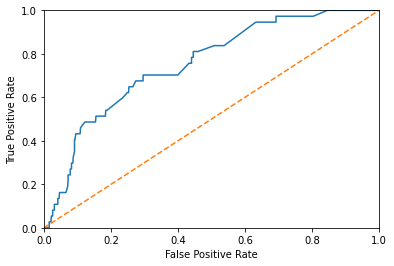

In [22]:
import matplotlib.pyplot as plt

y_pred_proba = best_model_pipeline.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [29]:
preds = best_model_pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       781
           1       0.14      0.49      0.21        37

    accuracy                           0.84       818
   macro avg       0.55      0.67      0.56       818
weighted avg       0.93      0.84      0.88       818



In [30]:
roc_auc_score(y_test, preds)

0.6702598885697477

In [33]:
preds = best_model_pipeline.predict(X_unseen)
print(classification_report(y_unseen, preds))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       959
           1       0.18      0.44      0.25        62

    accuracy                           0.84      1021
   macro avg       0.57      0.65      0.58      1021
weighted avg       0.91      0.84      0.87      1021



In [34]:
roc_auc_score(y_unseen, preds)

0.6520485048269367